In [40]:
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/Users/antonhesse/Desktop/Anton/Education/UMN/PhD/Dissertation/CPET_scoping_review/code/cpet_articles/analysis/helper_funcs')
from text_analysis import tokenize_file

In [3]:
# get txt file paths and stems
txt_file_paths = list(Path('/Users/antonhesse/Desktop/Anton/Education/UMN/PhD/Dissertation/CPET_scoping_review/data/cpet_articles/full_texts/txts').glob('*.txt'))
txt_file_stems = [path.stem for path in txt_file_paths]

In [4]:
# load human eligibility data frame
human_df = pd.read_csv('/Users/antonhesse/Desktop/Anton/Education/UMN/PhD/Dissertation/CPET_scoping_review/data/cpet_articles/text_analysis/eligibility/Eligibility - human.csv')
human_df = human_df[~human_df['human'].isna()].drop_duplicates().reset_index(drop=True)
# human_df

In [5]:
# gather file paths of articles used to build random forest ML model
file_paths_for_model = [path for path in txt_file_paths if path.stem in human_df['doi_suffix'].to_list()]
file_stems_for_model = [path.stem for path in file_paths_for_model]

files_df = pd.DataFrame(
    {'doi_suffix': file_stems_for_model,
    'file_path': file_paths_for_model}
)

In [6]:
# merge files_df with human_df
merge_df = pd.merge(files_df, human_df.drop(['file_path', 'pred_human', 'pred_0.5'], axis=1), how='inner', on='doi_suffix')
merge_df

,doi_suffix,file_path,human
0,s00421-007-0554-0,/Users/antonhesse/Desktop/Anton/Education/UMN/...,True
1,s40279-021-01523-9,/Users/antonhesse/Desktop/Anton/Education/UMN/...,True
2,jbc.m117.817510,/Users/antonhesse/Desktop/Anton/Education/UMN/...,False
3,ijspp.2013-0486,/Users/antonhesse/Desktop/Anton/Education/UMN/...,True
4,s12984-018-0401-z,/Users/antonhesse/Desktop/Anton/Education/UMN/...,True
...,...,...,...
1915,jbc.m112.440354,/Users/antonhesse/Desktop/Anton/Education/UMN/...,False
1916,s0955-2863_._01_._00173-5,/Users/antonhesse/Desktop/Anton/Education/UMN/...,False
1917,chest.107.5.1206,/Users/antonhesse/Desktop/Anton/Education/UMN/...,True
1918,a-1273-7589,/Users/antonhesse/Desktop/Anton/Education/UMN/...,True


In [7]:
# tokenize files
merge_df['tokens'] = merge_df['file_path'].progress_apply(lambda x: tokenize_file(x, mode='lemm'))

  0%|          | 0/1920 [00:00<?, ?it/s]

In [8]:
# remove None values and join tokens
merge_df = merge_df[merge_df['tokens'].notnull()].reset_index(drop=True)
merge_df['joined_tokens'] = merge_df['tokens'].progress_apply(lambda x: ' '.join(x))

  0%|          | 0/1919 [00:00<?, ?it/s]

In [9]:
# load vetorizer and model
vectorizer = TfidfVectorizer(stop_words='english')
rf_clf = RandomForestClassifier(verbose=1)

In [10]:
# train model and get current accuracy
X = vectorizer.fit_transform(merge_df['joined_tokens'].to_list())
rf_clf.fit(X.toarray(), merge_df['human'].to_list())
y = merge_df['human'].to_list()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 11.5min finished


RandomForestClassifier(verbose=1)

In [11]:
# uncomment remaining lines to check current accuracy. It takes a very long time
rskf_cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2)
scores = cross_val_score(rf_clf, X.toarray(), merge_df['human'].to_list(), cv = rskf_cv)
mean_score = round(np.mean(scores),3)*100
print(f'Current Accuracy: {mean_score}%')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   26.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Current Accuracy: 93.4%


In [36]:
rskf_cv1 = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1)
y_pred = cross_val_predict(rf_clf, X.toarray(), y, cv=rskf_cv1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   25.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

array([ True,  True, False, ...,  True,  True,  True])

In [43]:
merge_df['human'].value_counts()

True     1247
False     672
Name: human, dtype: int64

Text(0.5, 1.0, 'Confusion Matrix for Human/Non-human Classification')

<Figure size 576x432 with 0 Axes>

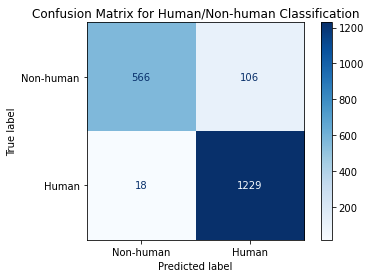

In [44]:
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Non-human', 'Human']
)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Human/Non-human Classification')

In [22]:
# load bbb articles and remove known ineligible articles
all_bbb_articles = pd.read_csv('/Users/antonhesse/Desktop/Anton/Education/UMN/PhD/Dissertation/CPET_scoping_review/data/cpet_articles/text_analysis/all_bbb_articles.csv')
ineligible_articles = pd.read_csv('/Users/antonhesse/Desktop/Anton/Education/UMN/PhD/Dissertation/CPET_scoping_review/data/cpet_articles/text_analysis/eligibility/ineligible_articles_combined.csv')
bbb_articles = all_bbb_articles[~all_bbb_articles['doi_suffix'].isin(ineligible_articles['doi_suffix'])].drop_duplicates().reset_index(drop=True)

In [23]:
# find subset of bbb article file stems that are not human_df
remaining_bbb_file_paths = [path for path in txt_file_paths if path.stem in bbb_articles['doi_suffix'].to_list() and path.stem not in human_df['doi_suffix'].to_list()]
remaining_bbb_file_stems = [path.stem for path in remaining_bbb_file_paths]

In [25]:
test_texts = []
for path in tqdm(remaining_bbb_file_paths, total=len(remaining_bbb_file_paths)):
    try:
        tokens = tokenize_file(path, mode='lemm')
        if tokens is not None:
            tokens = ' '.join(tokens)
        test_texts.append(tokens)
    except FileNotFoundError as e:
        print(e)
        test_texts.append(None)

  0%|          | 0/7904 [00:00<?, ?it/s]

In [26]:
# create test data frame
test_df = pd.DataFrame({
    'doi_suffix': [path.stem for path in remaining_bbb_file_paths],
    'file_path': [path for path in remaining_bbb_file_paths],
    'joined_tokens': test_texts
})
test_df = test_df[~test_df['joined_tokens'].isna()].reset_index(drop=True)
# test_df

In [27]:
# create predictions and calculate probabilities
X_test = vectorizer.transform(test_texts)
preds = rf_clf.predict_proba(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.3s finished


In [28]:
# create output data frame
out_df = test_df.drop('joined_tokens', axis=1)

out_df['pred_false'] = preds[:,0]
out_df['pred_true'] = preds[:,1]
out_df['pred_0.5'] = abs(preds[:,0]-0.5)
out_df['pred_human'] = out_df.apply(lambda x: False if x['pred_false'] > 0.5 else True, axis=1)
out_df.insert(2, 'human', None)

out_df = out_df.reindex(columns=['doi_suffix', 'file_path', 'human', 'pred_human', 'pred_0.5'])
# out_df

In [29]:
# concatenate output df with human_df
comb_df = pd.concat([human_df, out_df])
comb_df = comb_df.sort_values(['human', 'pred_human', 'pred_0.5'], ascending=False).reset_index(drop=True)
comb_df['doi_suffix'] = comb_df['doi_suffix'].astype('str')
# comb_df

In [30]:
comb_df

,doi_suffix,file_path,human,pred_human,pred_0.5
0,s004210050238,/Users/antonhesse/Desktop/Anton/Education/UMN/...,True,True,0.19
1,s1566-0702_._01_._00340-x,/Users/antonhesse/Desktop/Anton/Education/UMN/...,True,True,0.19
2,jeb.054452,/Users/antonhesse/Desktop/Anton/Education/UMN/...,True,True,0.19
3,ep088977,/Users/antonhesse/Desktop/Anton/Education/UMN/...,True,True,0.19
4,0034-5687_._93_._90088-r,/Users/antonhesse/Desktop/Anton/Education/UMN/...,True,True,0.19
...,...,...,...,...,...
9845,02640410701305420,/Users/antonhesse/Desktop/Anton/Education/UMN/...,None,True,0.14
9846,jappl.2001.90.2.538,/Users/antonhesse/Desktop/Anton/Education/UMN/...,None,True,0.14
9847,japplphysiol.00690.2001,/Users/antonhesse/Desktop/Anton/Education/UMN/...,None,True,0.12
9848,ajpendo.1998.274.1.e72,/Users/antonhesse/Desktop/Anton/Education/UMN/...,None,True,0.11


In [ ]:
comb_df.to_clipboard(index=False)

In [ ]:
comb_df.to_csv(Path(
    '/Users/antonhesse/Desktop/Anton/Education/UMN/PhD/Dissertation/CPET_scoping_review/data/cpet_articles/text_analysis/eligibility/pred_human.csv'),
    index=False)